In [15]:
from AGNCatalogToolbox import main as agn
from colossus.cosmology import cosmology
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# my cosmology
params = {'flat': True, 'H0': 70., 'Om0': 0.3, 'Ob0': 0.049, 'sigma8':0.81, 'ns':0.95}
cosmology.addCosmology('Carraro+20', params)

In [3]:
cosmo = 'Carraro+20'
cosmology = cosmology.setCosmology(cosmo)
volume = 200**3

In [4]:
z = 1
gals = pd.DataFrame()

In [7]:
gals['halos'] = agn.generate_semi_analytic_halo_catalogue(volume, (12, 16, 0.1), z, 0.7)
gals['stellar_mass'] = agn.halo_mass_to_stellar_mass(gals['halos'], z)
gals['black_hole_mass'] = agn.stellar_mass_to_black_hole_mass(gals['stellar_mass'], method="Shankar16", scatter="Intrinsic")

Scatter is a thing, valued at 0.11


In [8]:
gals['duty_cycle'] = agn.to_duty_cycle("Geo", gals['stellar_mass'], gals['black_hole_mass'], z)

Warning - we have requested redshift 1 - Selecting file Geo17DCz0.75.csv as it is closest


In [9]:
# Schechter parameters fitting
#redshift = [0.1, 1, 2]
#alpha = [-0.25,1.6,7.14]
#lambd = [0.05, -0.8,-0.5]
#alpha_pars=np.polyfit(redshift,alpha,2)
#lambda_pars=np.polyfit(redshift,lambd,2)
#np.savez('schechter_pars.npz',alpha_pars=alpha_pars,lambda_pars=lambda_pars)

schechter_pars=np.load('schechter_pars.npz')
alpha_pars=schechter_pars['alpha_pars']
lambda_pars=schechter_pars['lambda_pars']

alpha_pol=np.poly1d(alpha_pars)
lambda_pol=np.poly1d(lambda_pars)

alpha_z=alpha_pol(z)
lambda_z=lambda_pol(z)

In [10]:
gals['luminosity'] = agn.black_hole_mass_to_luminosity(gals['black_hole_mass'], gals['duty_cycle'], gals['stellar_mass'], z,"Schechter",
                                        bol_corr='Lusso12_modif', parameter1=lambda_z, parameter2=-0.65)

In [11]:
gals['nh'] = agn.luminosity_to_nh(gals['luminosity'], z)
gals['agn_type'] = agn.nh_to_type(gals['nh'])

In [12]:
gals['logSFR'] = agn.SFR(z,gals['stellar_mass'],'Carraro20')

In [13]:
gals.head()

,halos,stellar_mass,black_hole_mass,duty_cycle,luminosity,nh,agn_type,logSFR
0,14.515975,11.810767,8.692241,0.331491,42.909860,29.317731,3.0,1.207773
1,14.440985,11.907193,9.347409,0.365181,42.645504,27.940663,3.0,1.064409
2,14.386534,11.936206,9.398314,0.374161,43.301349,28.578625,3.0,0.635392
3,14.354356,11.964867,9.168308,0.383249,42.417975,29.060316,3.0,1.004776
4,14.319603,11.860725,9.149873,0.348879,42.423826,26.375548,3.0,0.848995


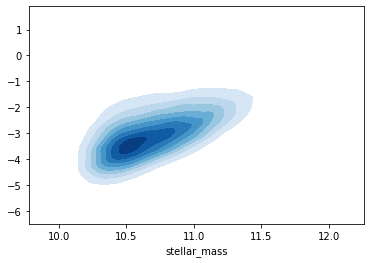

In [16]:
sns.kdeplot(gals.stellar_mass,(gals.luminosity-42)-gals.logSFR, cmap="Blues", shade=True, shade_lowest=False, );
#plt.plot(gals.stellar_mass,10**(gals.logSFR)/10**(gals.luminosity-42))

In [58]:
   #Fits from table2, type2, Spectro+photo,488
a1=0.23
a2=0.05
a3=0.001
b=1.256
incr=0.01
#limits from fig 9 Lbol=[9.8-12.2]
Lbol2=np.arange(start=9.8,stop=12.2, step=incr)
x=Lbol2-12
bol_corr2=a1*x+a2*x**2+a3*x**3+b
L_210_2=Lbol2-bol_corr2+33.585 #from Lsun to erg/s
plt.plot(L_210_2,10**bol_corr2)
plt.yscale('log')

#Fits from table2, type1, Spectro+photo,373
a1=0.288
a2=0.111
a3=-0.007
b=1.308
# limits from fig 9 Lbol=[10.8-13.2]
L_max=13.55 # where bol_corr1=100
Lbol1=np.arange(start=10.8,stop=L_max, step=incr)
x=Lbol1-12
bol_corr1=a1*x+a2*x**2+a3*x**3+b
L_210_1=Lbol1-bol_corr1+33.585 #from Lsun to erg/s
plt.plot(L_210_1,10**bol_corr1)

#Combine equations, eq 1 from Lusso 2012
start=np.min(Lbol1)
ending=np.max(Lbol2)
LX=np.arange(start=start,stop=ending, step=incr)
x=Lbol1-12
a1=0.288
a2=0.111
a3=-0.007
b=1.308
bol_corr12=a1*x+a2*x**2+a3*x**3+b

a1=0.23
a2=0.05
a3=0.001
b=1.256
bol_corr22=a1*x+a2*x**2+a3*x**3+b

bol_tot=bol_corr12*(LX-start)/(ending-start)+bol_corr22*(ending-LX)/(ending-start)
L_210_tot=LX-bol_tot+33.585
plt.plot(L_210_tot,10**bol_tot)

# Low luminosity (She et al. 2017)
lx_final=np.arange(start=36,stop=np.min(L_210_2), step=incr)
low_lum = alog10(16)*np.ones(size(lx_final))

# Compose to make one array:
a = [L_210_2 < np.min(L_210_1)]
# low lum + AGN2
lx_final = np.concatenate((lx_final,L_210_2[a]))
corr_final = np.concatenate((low_lum,bol_corr2[a]))
# + intermidiate area
lx_final = np.concatenate((lx_final,L_210_tot))
corr_final = np.concatenate((corr_final,bol_tot))
# + AGN1 up to 100
a = [L_210_1 > np.max(L_210_2)]
lx_final = np.concatenate((lx_final,L_210_1[a]))
corr_final = np.concatenate((corr_final,bol_corr1[a]))
# + flat area
lx_high = np.arange(start=max(L_210_1),stop=46,step=incr)
corr_high=2*np.ones(size(lx_high))
l210_final = np.concatenate((lx_final,lx_high))
corr_final = np.concatenate((corr_final,corr_high))

ValueError: operands could not be broadcast together with shapes (275,) (139,) 

In [61]:
print(len(bol_corr12))
print(len(LX))
print(len(bol_corr22))

275
139
275


In [ ]:
def lusso(x, a1, a2, a3, b):
   return a1*x + a2*x**2 + a3*x**3 + b